In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from ast import literal_eval
from sklearn.metrics import confusion_matrix
import itertools
import time

# <a id="code0">KNN K-Nearest Neighbors</a>

### Cross Validation modifying random_parameter at splitting the dataset

KNN accuracy improved without median Zero and target values (0, 1)

In [2]:
df_full = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted.csv')
df = df_full.copy()
df.loc[(df['Ranking'] <= 250), 'Top_250'] = 1
df.loc[(df['Ranking'] > 250), 'Top_250'] = 0
df.loc[(df['Ranking'] <= 500), 'Top_500'] = 1
df.loc[(df['Ranking'] > 500), 'Top_500'] = 0

Generating Feature set permutations

In [687]:
features = ['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum','Restaurant', 'Company', 'Liffey', 'Price Area']
feat_combo = []
for L in range(1, len(features)+1):
    for subset in itertools.combinations(features, L):
        feat_combo.append(subset)
print ('There are {} different combinations of feature set'.format(len(feat_combo)))

There are 2047 different combinations of feature set


In [695]:
knn_total_top_250 = pd.DataFrame(columns=['combo', 'accuracy', 'k', 'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])

In [710]:
knn_total_top_500 = pd.DataFrame(columns=['combo', 'accuracy', 'k', 'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])

In [711]:
start = time.time()
# limiting the samples scope in order to have y-variance close to unit (defining 1,-1 binomial target) for a balanced model
dff = df.loc[df['Ranking'] <= 1500].copy() # 500/1500
space = '     ' # to print on same line while calculating
knn_combo = pd.DataFrame(columns=['combo', 'accuracy', 'k', 'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])
j=0
i=0
for j in range(0, 100, 3):
    for i in range (0, len(feat_combo)):
        X = dff[list(feat_combo[i])].values 
        y = dff['Top_500'].values #Top_250/Top_500
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=j)        
        Ks = 20
        mean_acc = np.zeros((Ks-1))
        std_acc = np.zeros((Ks-1))
        ConfustionMx = [];
        for n in range(1,Ks):
            neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
            yhat=neigh.predict(X_test)
            mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
            std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
        
        knn_combo.at[i, 'combo'] = list(feat_combo[i])
        knn_combo.at[i, 'accuracy'] = mean_acc.max()
        knn_combo.at[i, 'f1_score'] = f1_score(y_test, yhat, average='weighted')
        knn_combo.at[i, 'jaccard_score'] = jaccard_score(y_test, yhat, average='weighted')
        knn_combo.at[i, 'random_state'] = j
        knn_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))
        knn_combo.at[i, 'k'] = mean_acc.argmax()+1
        
        print( 'random_state:{},{}{}'.format(j, knn_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
    knn_total_top_500 = knn_total_top_500.append(knn_combo) #Top_250/Top_500
print(round(time.time() - start, 3))

7541.574tate:99,['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum', 'Restaurant', 'Company', 'Liffey', 'Price Area']                                                  


In [713]:
#knn_total_top_500.to_csv('CSVs/knn_total_top_500.csv', index=False)

Passing object type to float in the dataframes

In [720]:
for column in list(knn_total_top_250.columns)[1:]:
    knn_total_top_250[column] = knn_total_top_250[column].astype('float')
for column in list(knn_total_top_500.columns)[1:]:
    knn_total_top_500[column] = knn_total_top_500[column].astype('float')

In [1237]:
knn_total_top_250.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,k,f1_score,jaccard_score,random_state,nFeatures
519,"[Cafe, Museum, Company, Liffey]",0.75,10.0,0.565267,0.395804,15.0,4.0
387,"[Tourism, Cafe, Luas, Company]",0.75,7.0,0.580420,0.409722,15.0,4.0


In [1123]:
knn_total_top_500.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,k,f1_score,jaccard_score,random_state,nFeatures
735,"[Hotel, Cafe, Company, Liffey, Price Area]",0.729167,16.0,0.639183,0.481204,72.0,5.0
18,"[Hotel, Company]",0.723958,18.0,0.694792,0.537506,72.0,2.0


for each random_state, the minimum k value for the maximum accuracy calculated for all 2047 feature set combinations

In [764]:
rs_group_250 = list(knn_total_top_250.groupby(by=['random_state'])[['accuracy', 'k']])
rs_group_500 = list(knn_total_top_500.groupby(by=['random_state'])[['accuracy', 'k']])
min_k_250 = {}
min_k_500 = {}
i=0
for i in range(0, len(rs_group_250)):
    min_k_250[rs_group_250[i][0]] = rs_group_250[i][1].loc[(rs_group_250[i][1]['accuracy'] 
                                        == rs_group_250[i][1]['accuracy'].max()), 'k'].min()
i=0
for i in range(0, len(rs_group_500)):
    min_k_500[rs_group_500[i][0]] = rs_group_500[i][1].loc[(rs_group_500[i][1]['accuracy'] 
                                        == rs_group_500[i][1]['accuracy'].max()), 'k'].min()

In [912]:
int(0.5 + sum(min_k_250.values())/len(min_k_250.values()))

10

In [913]:
int(0.5 + sum(min_k_500.values())/len(min_k_500.values()))

11

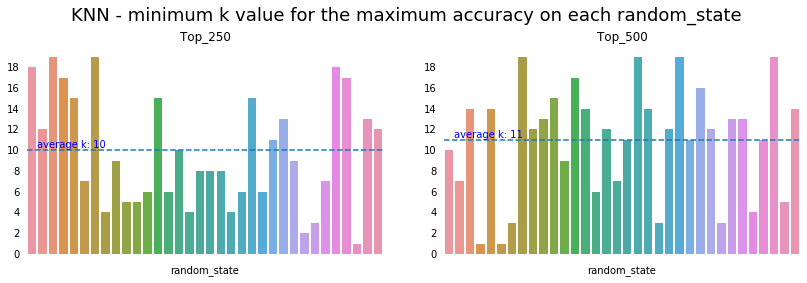

In [933]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=3.0)
fig.suptitle('KNN - minimum k value for the maximum accuracy on each random_state', y=1.02, fontsize=18)

g1 = sns.barplot(x=list(min_k_250.keys()), y=list(min_k_250.values()), ax=ax[0])
g1.set(xticklabels=[], title='Top_250', xlabel='random_state')
g1.yaxis.set_major_locator(plt.MultipleLocator(2))
#sns.lineplot(y=int(0.5 + sum(min_k_250.values())/len(min_k_250.values())), label='av 10', ax=ax[0])

g2 = sns.barplot(x=list(min_k_500.keys()), y=list(min_k_500.values()), ax=ax[1])
g2.set(xticklabels=[], title='Top_500', xlabel='random_state')
g2.yaxis.set_major_locator(plt.MultipleLocator(2))
ax[0].tick_params(labelleft=True, left=False, bottom=False) 
ax[0].axhline(int(0.5 + sum(min_k_250.values())/len(min_k_250.values())), ls='--')
ax[0].text(0.5, 0.2+int(0.5 + sum(min_k_250.values())/len(min_k_250.values())), 
           "average k: {}".format(str(int(0.5 + sum(min_k_250.values())/len(min_k_250.values())))), color='blue')
ax[1].tick_params(labelleft=True, left=False, bottom=False)  
ax[1].axhline(int(0.5 + sum(min_k_500.values())/len(min_k_500.values())), ls='--')
ax[1].text(0.5, 0.2+int(0.5 + sum(min_k_500.values())/len(min_k_500.values())),
           "average k: {}".format(str(int(0.5 + sum(min_k_500.values())/len(min_k_500.values())))), color='blue')

fig.savefig('charts/KNN_min_k_value.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

Maximum, minimum & average mean for each random state

In [882]:
knn_acc_max_250 = knn_total_top_250.groupby(by=['random_state'])['accuracy'].max()
knn_acc_mean_250 = knn_total_top_250.groupby(by=['random_state'])['accuracy'].mean()
knn_acc_min_250 = knn_total_top_250.groupby(by=['random_state'])['accuracy'].min()

knn_acc_max_500 = knn_total_top_500.groupby(by=['random_state'])['accuracy'].max()
knn_acc_mean_500 = knn_total_top_500.groupby(by=['random_state'])['accuracy'].mean()
knn_acc_min_500 = knn_total_top_500.groupby(by=['random_state'])['accuracy'].min()

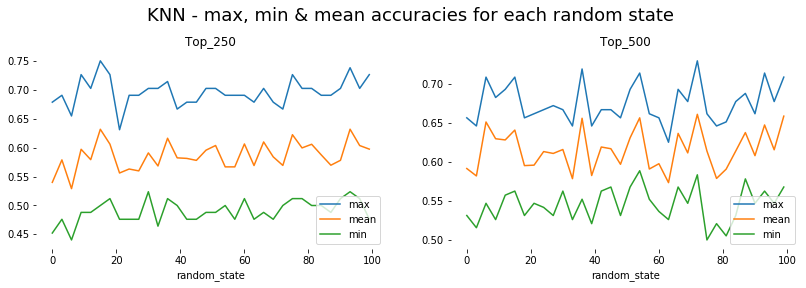

In [899]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=3.5)
fig.suptitle('KNN - max, min & mean accuracies for each random state', y=1.02, fontsize=18)

g1 = sns.lineplot(x=knn_acc_max_250.index, y=knn_acc_max_250.values, label='max', ax=ax[0])
sns.lineplot(x=knn_acc_mean_250.index, y=knn_acc_mean_250.values, label='mean',ax=ax[0])
sns.lineplot(x=knn_acc_min_250.index, y=knn_acc_min_250.values, label='min',ax=ax[0])
g1.set(title='Top_250')
g2 = sns.lineplot(x=knn_acc_max_500.index, y=knn_acc_max_500.values, label='max',ax=ax[1])
sns.lineplot(x=knn_acc_mean_500.index, y=knn_acc_mean_500.values, label='mean',ax=ax[1])
sns.lineplot(x=knn_acc_min_500.index, y=knn_acc_min_500.values, label='min',ax=ax[1])
g2.set(title='Top_500')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')

fig.savefig('charts/KNN_accuracies_random_state.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### <a id="code1">KNN Cross Validation using K-Fold and cross_val_score</a>

### Top_250

As we have estimated, the average k value (neighbours within range) is:
* 10 for Top_250
* 11 for Top_500

However, if we use the average k value with our script which iterates for all possible combination of features(combos), we would not get the optimal results. Fortunately, we already had calculated the best k value for different random_state. So we can calculate the average k value for each combo using 34 random_state per combo.<br> int(0.5 + np.mean(knn_total_top_250.at[0,'k'])) would be the average k for random_state = 0 <br>
0.5 is added in order to round the float to the closest integer <br>
Then we just include this k value within the combo's loop

In [1026]:
KNN_KF_CV_250 = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures', 'knn_k'])

In [1116]:
KNN_KF_CV_500 = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures', 'knn_k'])

In [1117]:
start = time.time()
#n=10 #10 Top_250 / 11 Top_500
# limiting the samples scope in order to have y-variance close to unit (defining 1,-1 binomial target) for a balanced model
dff = df.loc[df['Ranking'] <= 1500].copy()
space = '     ' # to print on same line while calculating
# iterated dataframe
knn_combo = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures', 'knn_k'])
i=0
for i in range (0, len(feat_combo)):
    n = int(0.5 + np.mean(knn_total_top_500.at[i,'k'])) # optimal knn  k-value for this specific combo
    # adding features and target                        # 0.5 is added in order to round the float to the closest integer
    X = dff[list(feat_combo[i])].values 
    y = dff['Top_500'].values
    # setting the classifier
    clf = KNeighborsClassifier(n_neighbors = n)
    
    # KFold
    scores = []
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    # cross_val_score
    cv_scores = cross_val_score(clf, X, y, cv=10)
    
    # adding to iterated dataframe
    knn_combo.at[i, 'combo'] = 'fixing bug passing a list into a cell not being an object'
    knn_combo.at[i, 'combo'] = list(feat_combo[i])
    knn_combo.at[i, 'KF_acc_mean'] = np.mean(scores)
    knn_combo.at[i, 'KF_acc_max'] = np.max(scores)
    knn_combo.at[i, 'KF_acc_min'] = np.min(scores)
    knn_combo.at[i, 'KF_var'] = np.var(scores)
    knn_combo.at[i, 'CV_acc_mean'] = cv_scores.mean()
    knn_combo.at[i, 'CV_acc_max'] = cv_scores.max()
    knn_combo.at[i, 'CV_acc_min'] = cv_scores.min()
    knn_combo.at[i, 'CV_var'] = cv_scores.var()
    knn_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))
    knn_combo.at[i, 'knn_k'] = n

    print( '{}{}'.format(knn_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
# adding each row from the iterated dataframe to the final dataframe
KNN_KF_CV_500 = KNN_KF_CV_500.append(knn_combo)
print(round(time.time() - start, 3))

150.992', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum', 'Restaurant', 'Company', 'Liffey', 'Price Area']                                                  


In [1069]:
KNN_KF_CV_250_k10.to_csv('CSVs/KNN_KF_CV_250_k10.csv', index=False)

In [1070]:
KNN_KF_CV_250.to_csv('CSVs/KNN_KF_CV_250.csv', index=False)

Dataframe with the means in order to visualize in a bar chart

In [1063]:
KNN_cc = pd.DataFrame(columns=['means_name', 'mean_k', 'optimal_k'])
means_name = ['KF_acc_max', 'KF_acc_mean',  'KF_acc_min', 'CV_acc_max', 'CV_acc_mean', 'CV_acc_min']
i=0
for i, mean in zip(range(0,7), means_name):
    KNN_cc.at[i, 'means_name'] = mean
    KNN_cc.at[i, 'mean_k'] = KNN_KF_CV_250_k10[mean].mean()
    KNN_cc.at[i, 'optimal_k'] = KNN_KF_CV_250[mean].mean()

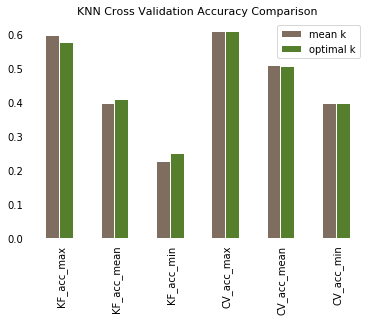

In [1068]:
barWidth = 0.25
bars1 = list(KNN_cc.iloc[:,1])
bars2 = list(KNN_cc.iloc[:,2])
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

fig, ax = plt.subplots()
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='mean k')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='optimal k')
ax.tick_params(labelleft=True, left=False, bottom=False)  
plt.xticks([r-0.09 + barWidth for r in range(len(bars1))], list(KNN_cc['means_name']), rotation=90)
plt.title('KNN Cross Validation Accuracy Comparison', fontsize=11)

plt.legend()
plt.savefig('charts/KNN_comp_mean_vs_optimal_k.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

Minimal difference using the optimal k

In [1071]:
KNN_KF_CV_250.sort_values(by=['KF_acc_max'], ascending=False).head(2)

,combo,KF_acc_mean,KF_acc_max,KF_acc_min,KF_var,CV_acc_mean,CV_acc_max,CV_acc_min,CV_var,nFeatures,knn_k
10,[Price Area],0.342973,0.952381,0,0.143265,0.515447,0.595238,0.428571,0.002476,1,6
167,"[University, Museum, Liffey]",0.434901,0.761905,0.190476,0.0348706,0.525087,0.585366,0.439024,0.00167652,3,6


Converting columns object to float to work with

In [1073]:
for column in list(KNN_KF_CV_250.columns)[1:]:
    KNN_KF_CV_250[column] = KNN_KF_CV_250[column].astype('float')

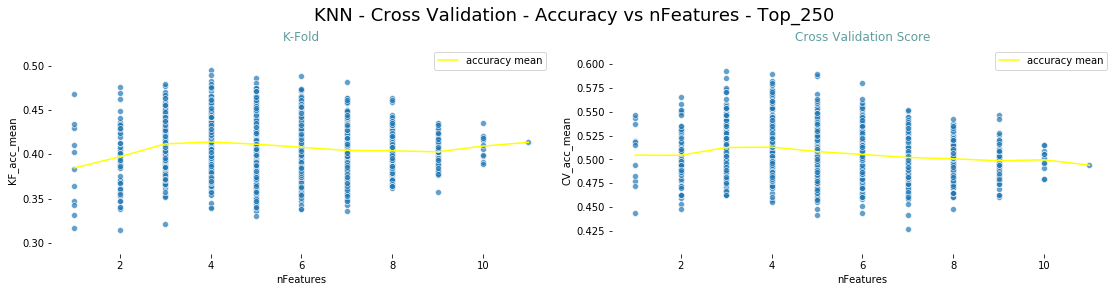

In [1074]:
figures = [0, 1]
axis_x = 'nFeatures'
axis_y = ['KF_acc_mean', 'CV_acc_mean']
titles_figs =['K-Fold', 'Cross Validation Score']
data = KNN_KF_CV_250
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
fig.tight_layout(pad=3.0)
fig.suptitle('KNN - Cross Validation - Accuracy vs nFeatures - Top_250', y=1.02, fontsize=18)

for ax_y, titl, figs in zip(axis_y, titles_figs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.7).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/KNN_Cross_Val_combo_nfeatures.png', bbox_inches='tight', format='png', dpi=500)

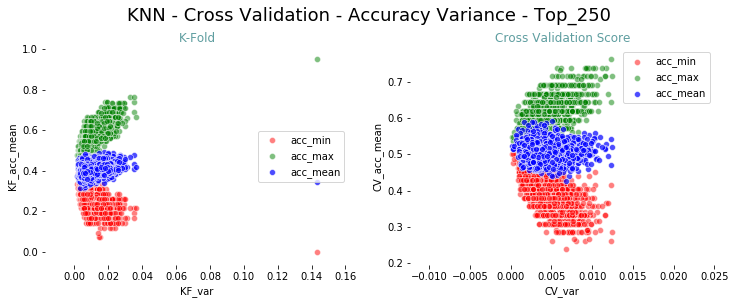

In [1075]:
figures = [0, 1]
axis_x = ['KF_var', 'CV_var']
axis_y_min = ['KF_acc_min', 'CV_acc_min']
axis_y_mean = ['KF_acc_mean', 'CV_acc_mean']
axis_y_max = ['KF_acc_max', 'CV_acc_max']
titles_figs =['K-Fold', 'Cross Validation Score']
data = KNN_KF_CV_250
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
fig.suptitle('KNN - Cross Validation - Accuracy Variance - Top_250', y=1.02, fontsize=18)
for ax_yi, ax_yea, ax_ya, ax_x, titl, figs in zip(axis_y_min, axis_y_mean, 
                                                  axis_y_max, axis_x, titles_figs, figures):
    sns.scatterplot(x=ax_x, y=ax_yi, data=data, alpha=0.5, 
                    label='acc_min', color='red', ax=axs[figs]).set_title(titl, color='cadetblue')
    sns.scatterplot(x=ax_x, y=ax_ya, data=data, alpha=0.5, 
                    label='acc_max', color='green', ax=axs[figs])
    sns.scatterplot(x=ax_x, y=ax_yea, data=data, alpha=0.7, 
                    label='acc_mean', color='blue', ax=axs[figs])
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/KNN_Cross_Val_Accuracy_Variance.png', bbox_inches='tight', format='png', dpi=500)

We can spot an outlier on the right hand side of the K-Fold chart

Saving the dataframe with a name that we can use later with new datasets without the need of changing variables.

In [1238]:
dfc = KNN_KF_CV_250.copy()

Now we can apply the same methodology that with SVM classifier. First at all, let's define some initial conditions in order to find the best combos (feature set):

* K-Fold < 0.01 variance & > 0.5 accuracy
* CV < 0.005 variance & > 0.6 accuracy
* combo always above mean() for same nFeature

In [1239]:
print('KFold: {}'.format(dfc.loc[(dfc['KF_var'] < 0.01) 
                        & (dfc['KF_acc_max'] > 0.5), 'nFeatures'].count()))
print('CV: {}'.format(dfc.loc[(dfc['CV_var'] < 0.005) 
                        & (dfc['CV_acc_max'] > 0.6), 'nFeatures'].count()))

KFold: 711
CV: 534


In [1240]:
KFold_1 = dfc.loc[(dfc['KF_var'] < 0.01) & (dfc['KF_acc_max'] > 0.5)].copy()
CV_1 = dfc.loc[(dfc['CV_var'] < 0.005) & (dfc['CV_acc_max'] > 0.6)].copy()
KFold_1.reset_index(drop=True, inplace=True)
CV_1.reset_index(drop=True, inplace=True)

We need the accuracy values of samples grouped by nFeatures (yellow accuracy mean on the chart)

In [1241]:
KFold_n_max = dfc.groupby(by=['nFeatures']).mean()['KF_acc_max'].values
KFold_n_mean = dfc.groupby(by=['nFeatures']).mean()['KF_acc_mean'].values
KFold_n_min = dfc.groupby(by=['nFeatures']).mean()['KF_acc_min'].values

CV_n_max = dfc.groupby(by=['nFeatures']).mean()['CV_acc_max'].values
CV_n_mean = dfc.groupby(by=['nFeatures']).mean()['CV_acc_mean'].values
CV_n_min = dfc.groupby(by=['nFeatures']).mean()['CV_acc_min'].values

applying the third condition:

* combo always above mean() for same nFeature

In [1242]:
KFold_2 = pd.DataFrame()
CV_2 = pd.DataFrame()
i=0
for i in range (0, len(KFold_1)):
    if (KFold_1.at[i, 'KF_acc_mean'] > KFold_n_mean[int(KFold_1.at[i, 'nFeatures'])-1]):
        if (KFold_1.at[i, 'KF_acc_min'] > KFold_n_min[int(KFold_1.at[i, 'nFeatures'])-1]):
            if (KFold_1.at[i, 'KF_acc_max'] > KFold_n_max[int(KFold_1.at[i, 'nFeatures'])-1]):
                KFold_2 = KFold_2.append(KFold_1.iloc[i,:])
i=0
for i in range (0, len(CV_1)):
    if (CV_1.at[i, 'CV_acc_mean'] > CV_n_mean[int(CV_1.at[i, 'nFeatures'])-1]):
        if (CV_1.at[i, 'CV_acc_min'] > CV_n_min[int(CV_1.at[i, 'nFeatures'])-1]):
            if (CV_1.at[i, 'CV_acc_max'] > CV_n_max[int(CV_1.at[i, 'nFeatures'])-1]):
                CV_2 = CV_2.append(CV_1.iloc[i,:])

In [1243]:
print('KFold group has been reduced from {} to {} samples'.format(KFold_1.shape[0], KFold_2.shape[0]))
print('CV group has been reduced from {} to {} samples'.format(CV_1.shape[0], CV_2.shape[0]))

KFold group has been reduced from 711 to 118 samples
CV group has been reduced from 534 to 308 samples


We compare KFold & CV groups to get matches

In [1244]:
match_list = []
for KF in KFold_2.combo:
    for CV in CV_2.combo:
        if KF==CV:
            match_list.append(KF)
print('We got {} matches'.format(len(match_list)))

We got 30 matches


In [1245]:
KFold_2.reset_index(drop=True, inplace=True)
knn_match = pd.DataFrame()
for combo in match_list:
    i=0
    for i in range(0, len(KFold_2)):
        if KFold_2.at[i, 'combo'] == combo:
            knn_match = knn_match.append(KFold_2.iloc[i,:])

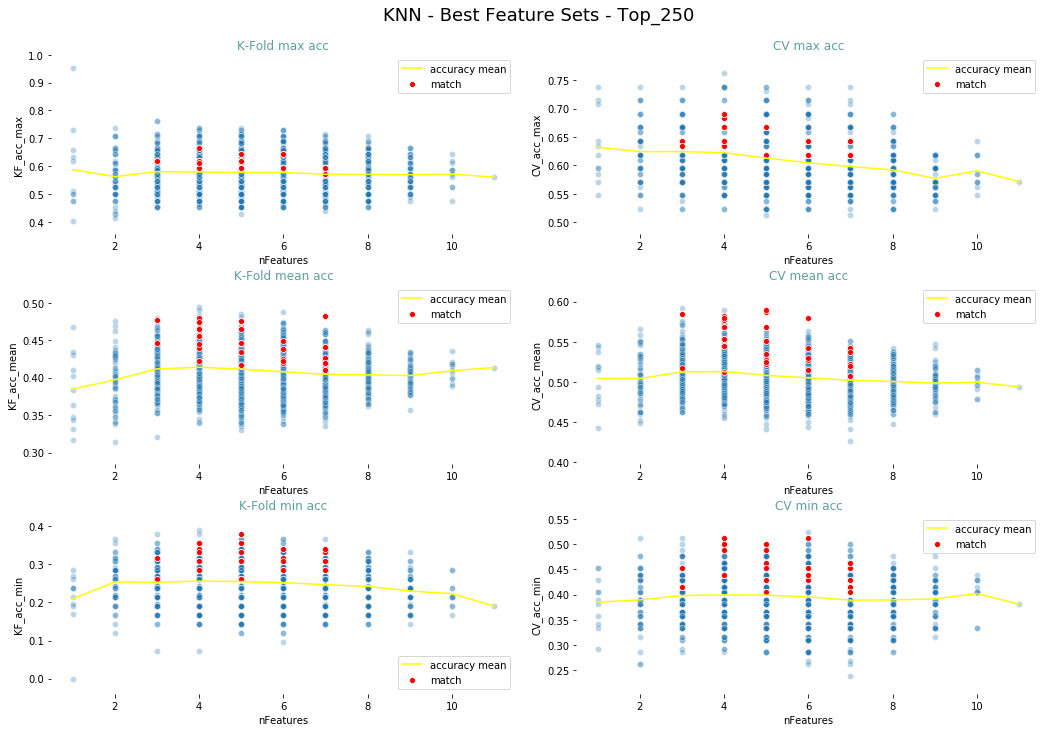

In [1106]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
axis_x = 'nFeatures'
axis_y = ['KF_acc_max', 'CV_acc_max', 'KF_acc_mean', 'CV_acc_mean', 'KF_acc_min', 'CV_acc_min']
titles_figs =['K-Fold max acc', 'CV max acc', 'K-Fold mean acc', 'CV mean acc', 'K-Fold min acc', 'CV min acc']
data = dfc
data_dfs = [KFold_2, CV_2, KFold_2, CV_2, KFold_2, CV_2]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
fig.tight_layout(pad=3.0)
fig.suptitle('KNN - Best Feature Sets - Top_250', y=1.02, fontsize=18)
#fig.suptitle('KNN - Top Feature Sets - Top_250', y=1.02, fontsize=18)

for ax_y, titl, data_df, figs in zip(axis_y, titles_figs, data_dfs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.3).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_df, ax=axs[figs], alpha=1, label='potential match', color='red')
    sns.scatterplot(x=axis_x, y=ax_y, data=knn_match, ax=axs[figs], alpha=1, label='match', color='red')
    #sns.scatterplot(x=axis_x, y=ax_y, data=svm_top_feats, ax=axs[figs], alpha=1, label='top feature set', color='black', marker='D')
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/KNN_Best_Feature_Sets_Top_250.png', bbox_inches='tight', format='png', dpi=500)

We have 30 different feature set for our model. We can narrow the group, so let's get the Top 10 Feature Sets as we did with SVM classifier.

we just start increasing the accuracy mean (yellow line) until we get 10 items in the match_list

In [1246]:
knn_top10_temp = match_list.copy()
KFold_2.reset_index(drop=True, inplace=True)
CV_2.reset_index(drop=True, inplace=True)
deltas = np.arange(1.01, 1.10, 0.01)

for delta in deltas: # we increase the accuracy mean 1% each iteration
    if len(knn_top10_temp) > 10:
        knn_top10_temp = []
        KFold_3 = pd.DataFrame()
        CV_3 = pd.DataFrame()
        i=0
        for i in range (0, len(KFold_2)):
            if (KFold_2.at[i, 'KF_acc_mean'] > (delta * (KFold_n_mean[int(KFold_2.at[i, 'nFeatures'])-1]))):
                if (KFold_2.at[i, 'KF_acc_min'] > (delta * (KFold_n_min[int(KFold_2.at[i, 'nFeatures'])-1]))):
                    if (KFold_2.at[i, 'KF_acc_max'] > (delta * (KFold_n_max[int(KFold_2.at[i, 'nFeatures'])-1]))):
                        KFold_3 = KFold_3.append(KFold_2.iloc[i,:])
        i=0
        for i in range (0, len(CV_2)):
            if (CV_2.at[i, 'CV_acc_mean'] > (delta * (CV_n_mean[int(CV_2.at[i, 'nFeatures'])-1]))):
                if (CV_2.at[i, 'CV_acc_min'] > (delta * (CV_n_min[int(CV_2.at[i, 'nFeatures'])-1]))):
                    if (CV_2.at[i, 'CV_acc_max'] > (delta * (CV_n_max[int(CV_2.at[i, 'nFeatures'])-1]))):
                        CV_3 = CV_3.append(CV_2.iloc[i,:])
        try:
            for KF in KFold_3['combo']:
                for CV in CV_3['combo']:
                    if KF==CV:
                        knn_top10_temp.append(KF)
            knn_top10_list = knn_top10_temp.copy()
        except:
            print('There are {} best combos with delta {}'.format(len(knn_top10_list), delta-0.01))
            break
    else:
        print('There are {} best combos with delta {}'.format(len(knn_top10_list), delta-0.01))
        break

There are 9 best combos with delta 1.03


In [1248]:
knn_top_feats = pd.DataFrame()
for combo in knn_top10_list:
    i=0
    for i in range(0, len(KFold_2)):
        if KFold_2.at[i, 'combo'] == combo:
            knn_top_feats = knn_top_feats.append(KFold_2.iloc[i,:])
KNN_CV_top_feats_Top_250 = knn_top_feats.copy()
KNN_CV_top_feats_Top_250.to_csv('CSVs/KNN_CV_top_feats_Top_250.csv', index=False)

In [1147]:
knn_top_feats

,CV_acc_max,CV_acc_mean,CV_acc_min,CV_var,KF_acc_max,KF_acc_mean,KF_acc_min,KF_var,combo,knn_k,nFeatures
22,0.666667,0.568002,0.487805,0.002007,0.609756,0.463008,0.357143,0.006719,"[Hotel, Pub, Luas, Restaurant]",5.0,4.0
28,0.666667,0.577642,0.487805,0.003234,0.666667,0.479152,0.341463,0.007244,"[Tourism, Cafe, Pub, Museum]",13.0,4.0
29,0.690476,0.582520,0.487805,0.003739,0.619048,0.465679,0.309524,0.009320,"[Tourism, Cafe, Museum, Restaurant]",12.0,4.0
30,0.690476,0.580139,0.500000,0.004047,0.619048,0.474448,0.341463,0.007451,"[Tourism, Pub, Museum, Restaurant]",9.0,4.0
32,0.642857,0.553717,0.500000,0.003060,0.609756,0.465563,0.333333,0.007678,"[Cafe, Pub, Luas, Museum]",8.0,4.0
38,0.666667,0.587573,0.500000,0.002923,0.619048,0.474739,0.357143,0.005449,"[Hotel, Tourism, Cafe, Pub, Museum]",11.0,5.0
56,0.666667,0.589895,0.500000,0.002569,0.642857,0.475029,0.333333,0.006859,"[Tourism, Cafe, Pub, Museum, Restaurant]",12.0,5.0
69,0.642857,0.580139,0.512195,0.002131,0.642857,0.448722,0.285714,0.009552,"[Hotel, Tourism, Cafe, Pub, Museum, Restaurant]",10.0,6.0
107,0.619048,0.520093,0.428571,0.003467,0.595238,0.419861,0.309524,0.006337,"[Tourism, University, Cafe, Luas, Restaurant, ...",7.0,7.0


In [1148]:
print('Top_250 K-Folds accuracy: {} %'.format(round(100*knn_top_feats.KF_acc_mean.mean(), 2)))
print('Top_250 Cross Validation accuracy: {} %'.format(round(100*knn_top_feats.CV_acc_mean.mean(), 2)))

Top_250 K-Folds accuracy: 46.29 %
Top_250 Cross Validation accuracy: 57.11 %


Top feature set are between 4 and 7 features

In [1149]:
feature_top = {'Hotel':0, 'Tourism':0, 'University':0, 'Cafe':0, 'Pub':0, 
               'Luas':0, 'Museum':0,'Restaurant':0, 'Company':0, 'Liffey':0, 'Price Area':0}
for feat in feature_top.keys():
    for combo in knn_top10_list:
        feature_top[feat] += combo.count(feat)
print(feature_top)

{'Hotel': 3, 'Tourism': 7, 'University': 1, 'Cafe': 7, 'Pub': 7, 'Luas': 3, 'Museum': 7, 'Restaurant': 6, 'Company': 1, 'Liffey': 0, 'Price Area': 1}


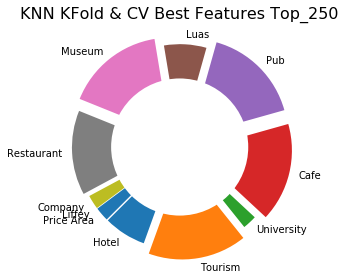

In [1150]:
labels = feature_top.keys()
sizes = feature_top.values()
explode = (0.05,0.15,0.05,0.15, 0.15,0.05,0.15,0.1,0.05,0.05,0.05)
plt.pie(sizes, labels=labels,  startangle=225, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('KNN KFold & CV Best Features Top_250', fontsize=16) 
plt.tight_layout()
plt.savefig('charts/KNN_KFold_CV_Best_Features_Top_250.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### KNN K-Fold & Cross Validation Score Top_500 

(following same methodology which we used with Top_250)

we ran the script for Top_250 with Top_500 parameters and got KNN_KF_CV_500 dataframe

In [1118]:
KNN_KF_CV_500.sort_values(by=['KF_acc_max'], ascending=False).head(2)

,combo,KF_acc_mean,KF_acc_max,KF_acc_min,KF_var,CV_acc_mean,CV_acc_max,CV_acc_min,CV_var,nFeatures,knn_k
10,[Price Area],0.468202,0.947368,0,0.0889921,0.508925,0.589474,0.427083,0.00233279,1,6
1021,"[Luas, Restaurant, Company, Liffey, Price Area]",0.553607,0.894737,0.229167,0.0578291,0.616579,0.684211,0.53125,0.0021251,5,12


In [1119]:
for column in list(KNN_KF_CV_500.columns)[1:]:
    KNN_KF_CV_500[column] = KNN_KF_CV_500[column].astype('float')

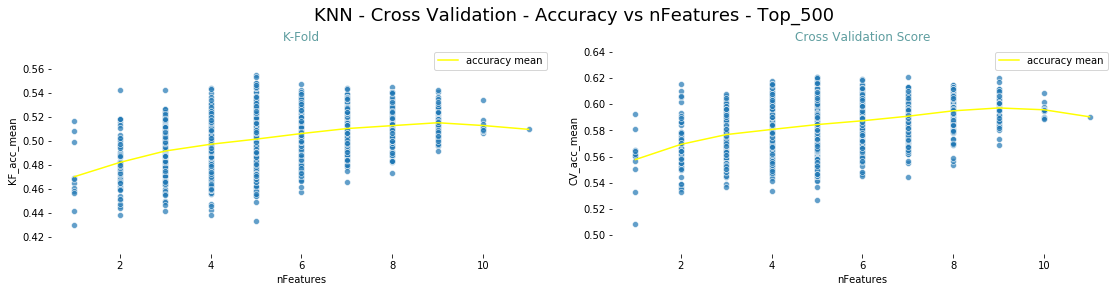

In [1120]:
figures = [0, 1]
axis_x = 'nFeatures'
axis_y = ['KF_acc_mean', 'CV_acc_mean']
titles_figs =['K-Fold', 'Cross Validation Score']
data = KNN_KF_CV_500
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
fig.tight_layout(pad=3.0)
fig.suptitle('KNN - Cross Validation - Accuracy vs nFeatures - Top_500', y=1.02, fontsize=18)

for ax_y, titl, figs in zip(axis_y, titles_figs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.7).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/KNN_Cross_Val_combo_nfeatures_Top_500.png', bbox_inches='tight', format='png', dpi=500)

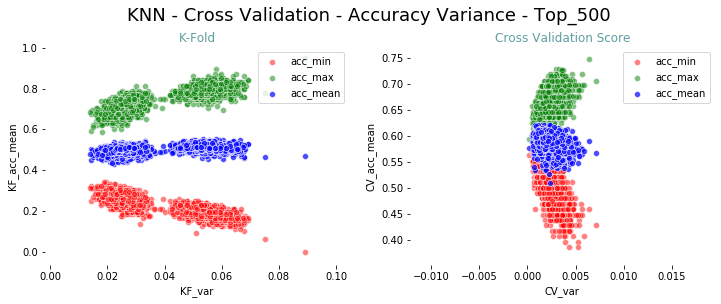

In [1121]:
figures = [0, 1]
axis_x = ['KF_var', 'CV_var']
axis_y_min = ['KF_acc_min', 'CV_acc_min']
axis_y_mean = ['KF_acc_mean', 'CV_acc_mean']
axis_y_max = ['KF_acc_max', 'CV_acc_max']
titles_figs =['K-Fold', 'Cross Validation Score']
data = KNN_KF_CV_500
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
fig.suptitle('KNN - Cross Validation - Accuracy Variance - Top_500', y=1.02, fontsize=18)
for ax_yi, ax_yea, ax_ya, ax_x, titl, figs in zip(axis_y_min, axis_y_mean, 
                                                  axis_y_max, axis_x, titles_figs, figures):
    sns.scatterplot(x=ax_x, y=ax_yi, data=data, alpha=0.5, 
                    label='acc_min', color='red', ax=axs[figs]).set_title(titl, color='cadetblue')
    sns.scatterplot(x=ax_x, y=ax_ya, data=data, alpha=0.5, 
                    label='acc_max', color='green', ax=axs[figs])
    sns.scatterplot(x=ax_x, y=ax_yea, data=data, alpha=0.7, 
                    label='acc_mean', color='blue', ax=axs[figs])
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/KNN_Cross_Val_Accuracy_Variance_Top_500.png', bbox_inches='tight', format='png', dpi=500)

Same code that earlier with different initial values (we pick them just having a look on the chart. We don't have to be accurate on this, due to we'll filter the results later till we get the optimal feature set for our model using the KNN classifier and Cross Validation in this case

In [1265]:
dfc = KNN_KF_CV_500.copy()

KFold_1 = dfc.loc[(dfc['KF_var'] < 0.03) & (dfc['KF_acc_max'] > 0.6)].copy()
CV_1 = dfc.loc[(dfc['CV_var'] < 0.003) & (dfc['CV_acc_max'] > 0.6)].copy()
KFold_1.reset_index(drop=True, inplace=True)
CV_1.reset_index(drop=True, inplace=True)

KFold_n_max = dfc.groupby(by=['nFeatures']).mean()['KF_acc_max'].values
KFold_n_mean = dfc.groupby(by=['nFeatures']).mean()['KF_acc_mean'].values
KFold_n_min = dfc.groupby(by=['nFeatures']).mean()['KF_acc_min'].values

CV_n_max = dfc.groupby(by=['nFeatures']).mean()['CV_acc_max'].values
CV_n_mean = dfc.groupby(by=['nFeatures']).mean()['CV_acc_mean'].values
CV_n_min = dfc.groupby(by=['nFeatures']).mean()['CV_acc_min'].values

KFold_2 = pd.DataFrame()
CV_2 = pd.DataFrame()
i=0
for i in range (0, len(KFold_1)):
    if (KFold_1.at[i, 'KF_acc_mean'] > KFold_n_mean[int(KFold_1.at[i, 'nFeatures'])-1]):
        if (KFold_1.at[i, 'KF_acc_min'] > KFold_n_min[int(KFold_1.at[i, 'nFeatures'])-1]):
            if (KFold_1.at[i, 'KF_acc_max'] > KFold_n_max[int(KFold_1.at[i, 'nFeatures'])-1]):
                KFold_2 = KFold_2.append(KFold_1.iloc[i,:])
i=0
for i in range (0, len(CV_1)):
    if (CV_1.at[i, 'CV_acc_mean'] > CV_n_mean[int(CV_1.at[i, 'nFeatures'])-1]):
        if (CV_1.at[i, 'CV_acc_min'] > CV_n_min[int(CV_1.at[i, 'nFeatures'])-1]):
            if (CV_1.at[i, 'CV_acc_max'] > CV_n_max[int(CV_1.at[i, 'nFeatures'])-1]):
                CV_2 = CV_2.append(CV_1.iloc[i,:])
                
print('KFold group has been reduced from {} to {} samples'.format(KFold_1.shape[0], KFold_2.shape[0]))
print('CV group has been reduced from {} to {} samples'.format(CV_1.shape[0], CV_2.shape[0]))

KFold group has been reduced from 912 to 61 samples
CV group has been reduced from 1701 to 444 samples


In [1266]:
match_list = []
for KF in KFold_2.combo:
    for CV in CV_2.combo:
        if KF==CV:
            match_list.append(KF)
print('We got {} matches'.format(len(match_list)))

We got 31 matches


In [1267]:
knn_top10_temp = match_list.copy()
KFold_2.reset_index(drop=True, inplace=True)
CV_2.reset_index(drop=True, inplace=True)
deltas = np.arange(1.01, 1.10, 0.01)

for delta in deltas: # we increase the accuracy mean 1% each iteration
    if len(knn_top10_temp) > 10:
        knn_top10_temp = []
        KFold_3 = pd.DataFrame()
        CV_3 = pd.DataFrame()
        i=0
        for i in range (0, len(KFold_2)):
            if (KFold_2.at[i, 'KF_acc_mean'] > (delta * (KFold_n_mean[int(KFold_2.at[i, 'nFeatures'])-1]))):
                if (KFold_2.at[i, 'KF_acc_min'] > (delta * (KFold_n_min[int(KFold_2.at[i, 'nFeatures'])-1]))):
                    if (KFold_2.at[i, 'KF_acc_max'] > (delta * (KFold_n_max[int(KFold_2.at[i, 'nFeatures'])-1]))):
                        KFold_3 = KFold_3.append(KFold_2.iloc[i,:])
        i=0
        for i in range (0, len(CV_2)):
            if (CV_2.at[i, 'CV_acc_mean'] > (delta * (CV_n_mean[int(CV_2.at[i, 'nFeatures'])-1]))):
                if (CV_2.at[i, 'CV_acc_min'] > (delta * (CV_n_min[int(CV_2.at[i, 'nFeatures'])-1]))):
                    if (CV_2.at[i, 'CV_acc_max'] > (delta * (CV_n_max[int(CV_2.at[i, 'nFeatures'])-1]))):
                        CV_3 = CV_3.append(CV_2.iloc[i,:])
        try:
            for KF in KFold_3['combo']:
                for CV in CV_3['combo']:
                    if KF==CV:
                        knn_top10_temp.append(KF)
            knn_top10_list = knn_top10_temp.copy()
        except:
            print('There are {} best combos with delta {}'.format(len(knn_top10_list), delta-0.01))
            break
    else:
        print('There are {} best combos with delta {}'.format(len(knn_top10_list), delta-0.01))
        break

There are 5 best combos with delta 1.02


In [1268]:
knn_top_feats = pd.DataFrame()
for combo in knn_top10_list:
    i=0
    for i in range(0, len(KFold_2)):
        if KFold_2.at[i, 'combo'] == combo:
            knn_top_feats = knn_top_feats.append(KFold_2.iloc[i,:])

In [1269]:
knn_top_feats

,CV_acc_max,CV_acc_mean,CV_acc_min,CV_var,KF_acc_max,KF_acc_mean,KF_acc_min,KF_var,combo,knn_k,nFeatures
4,0.673684,0.600921,0.531250,0.001715,0.778947,0.509276,0.302083,0.024181,"[Cafe, Liffey, Price Area]",11.0,3.0
6,0.666667,0.605110,0.510417,0.002249,0.768421,0.517818,0.239583,0.028180,"[Luas, Restaurant, Liffey]",11.0,3.0
34,0.694737,0.610362,0.541667,0.002003,0.778947,0.531382,0.281250,0.024440,"[Hotel, Pub, Luas, Museum, Liffey, Price Area]",11.0,6.0
38,0.684211,0.603037,0.531250,0.002099,0.778947,0.520943,0.270833,0.027230,"[Tourism, Cafe, Luas, Company, Liffey, Price A...",11.0,6.0
44,0.705263,0.612412,0.541667,0.001809,0.778947,0.526162,0.291667,0.026363,"[Luas, Museum, Restaurant, Company, Liffey, Pr...",11.0,6.0


In [1270]:
KNN_CV_top_feats_Top_500 = knn_top_feats.copy()

In [1271]:
#KNN_CV_top_feats_Top_500.to_csv('CSVs/KNN_CV_top_feats_Top_500.csv', index=False)

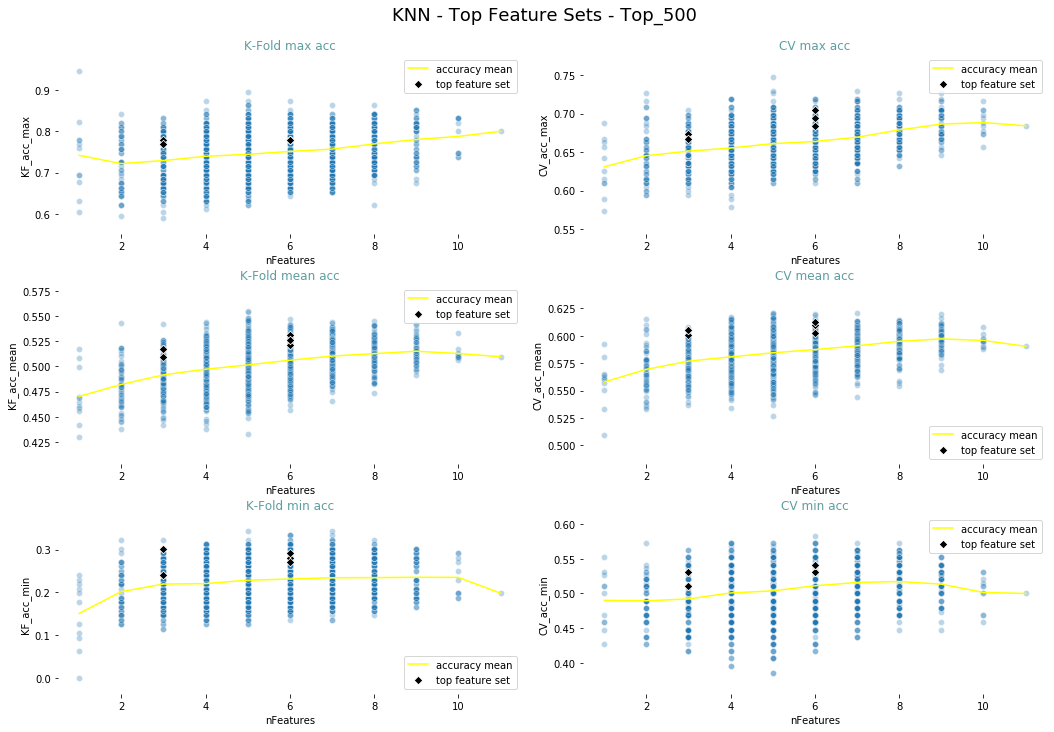

In [1131]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
axis_x = 'nFeatures'
axis_y = ['KF_acc_max', 'CV_acc_max', 'KF_acc_mean', 'CV_acc_mean', 'KF_acc_min', 'CV_acc_min']
titles_figs =['K-Fold max acc', 'CV max acc', 'K-Fold mean acc', 'CV mean acc', 'K-Fold min acc', 'CV min acc']
data = dfc
data_dfs = [KFold_2, CV_2, KFold_2, CV_2, KFold_2, CV_2]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
fig.tight_layout(pad=3.0)
fig.suptitle('KNN - Top Feature Sets - Top_500', y=1.02, fontsize=18)

for ax_y, titl, data_df, figs in zip(axis_y, titles_figs, data_dfs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.3).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_df, ax=axs[figs], alpha=1, label='potential match', color='red')
    #sns.scatterplot(x=axis_x, y=ax_y, data=knn_match, ax=axs[figs], alpha=1, label='match', color='green')
    sns.scatterplot(x=axis_x, y=ax_y, data=knn_top_feats, ax=axs[figs], alpha=1, label='top feature set', color='black', marker='D')
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/KNN_Top_Feature_Sets_Top_500.png', bbox_inches='tight', format='png', dpi=500)

In [1132]:
print('Top_500 K-Folds accuracy: {} %'.format(round(100*knn_top_feats.KF_acc_mean.mean(), 2)))
print('Top_500 Cross Validation accuracy: {} %'.format(round(100*knn_top_feats.CV_acc_mean.mean(), 2)))

Top_250 K-Folds accuracy: 52.11 %
Top_250 Cross Validation accuracy: 60.64 %


Top feature set are between 3 and 6 features

In [1133]:
feature_top = {'Hotel':0, 'Tourism':0, 'University':0, 'Cafe':0, 'Pub':0, 
               'Luas':0, 'Museum':0,'Restaurant':0, 'Company':0, 'Liffey':0, 'Price Area':0}
for feat in feature_top.keys():
    for combo in knn_top10_list:
        feature_top[feat] += combo.count(feat)
print(feature_top)

{'Hotel': 1, 'Tourism': 1, 'University': 0, 'Cafe': 2, 'Pub': 1, 'Luas': 4, 'Museum': 2, 'Restaurant': 2, 'Company': 2, 'Liffey': 5, 'Price Area': 4}


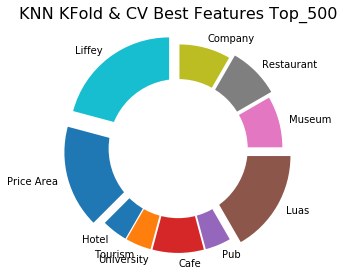

In [1135]:
labels = feature_top.keys()
sizes = feature_top.values()
explode = (0.05,0.05,0.05,0.05, 0.05,0.15,0.05,0.1,0.05,0.15,0.15)
plt.pie(sizes, labels=labels,  startangle=225, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('KNN KFold & CV Best Features Top_500', fontsize=16) 
plt.tight_layout()
plt.savefig('charts/KNN_KFold_CV_Best_Features_Top_500.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### <a id="code2">KNN KFold train set accuracy</a>

(considering best combinations of feature set)

Top_250

In [26]:
KNN_CV_top_feats_Top_250.combo

0               ['Hotel', 'Pub', 'Luas', 'Restaurant']
1                 ['Tourism', 'Cafe', 'Pub', 'Museum']
2          ['Tourism', 'Cafe', 'Museum', 'Restaurant']
3           ['Tourism', 'Pub', 'Museum', 'Restaurant']
4                    ['Cafe', 'Pub', 'Luas', 'Museum']
5        ['Hotel', 'Tourism', 'Cafe', 'Pub', 'Museum']
6    ['Tourism', 'Cafe', 'Pub', 'Museum', 'Restaura...
7    ['Hotel', 'Tourism', 'Cafe', 'Pub', 'Museum', ...
8    ['Tourism', 'University', 'Cafe', 'Luas', 'Res...
Name: combo, dtype: object

In [1298]:
n=10
dff = df.loc[df['Ranking'] <= 500].copy()                          
knn_train = []
for combo in KNN_CV_top_feats_Top_250.combo:
    X = dff[combo].values 
    y = dff['Top_250'].values
    clf = KNeighborsClassifier(n_neighbors = n)
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        knn_train.append(metrics.accuracy_score(y_train, yhat_train))

print('n Feature set: {}'.format(len(KNN_CV_top_feats_Top_250.combo)))
print('Number of results to calculate the average: {} x 10 Folds = {}'.format(len(KNN_CV_top_feats_Top_250.combo), len(knn_train)))
print('KNN K-Fold Train accuracy mean for best feature sets Top_250: {} %'.format(round(100*np.mean(knn_train), 2)))

n Feature set: 9
Number of results to calculate the average: 9 x 10 Folds = 90
KNN K-Fold Train accuracy mean for best feature sets Top_250: 66.28 %


Top_500

In [1272]:
KNN_CV_top_feats_Top_500.combo

4                            [Cafe, Liffey, Price Area]
6                            [Luas, Restaurant, Liffey]
34       [Hotel, Pub, Luas, Museum, Liffey, Price Area]
38    [Tourism, Cafe, Luas, Company, Liffey, Price A...
44    [Luas, Museum, Restaurant, Company, Liffey, Pr...
Name: combo, dtype: object

In [1299]:
n=10
dff = df.loc[df['Ranking'] <= 1500].copy()                          
knn_train = []
for combo in KNN_CV_top_feats_Top_500.combo:
    X = dff[combo].values 
    y = dff['Top_500'].values
    clf = KNeighborsClassifier(n_neighbors = n)
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        knn_train.append(metrics.accuracy_score(y_train, yhat_train))

print('n Feature set: {}'.format(len(KNN_CV_top_feats_Top_500.combo)))
print('Number of results to calculate the average: {} x 10 Folds = {}'.format(len(KNN_CV_top_feats_Top_500.combo), len(knn_train)))
print('KNN K-Fold Train accuracy mean for best feature sets Top_500: {} %'.format(round(100*np.mean(knn_train), 2)))

n Feature set: 5
Number of results to calculate the average: 5 x 10 Folds = 50
KNN K-Fold Train accuracy mean for best feature sets Top_500: 69.04 %


### <a id="code3">ROC Curve</a>

ROC displays a curve with a point for each of the True Positive Rate and False Positive Rate of the model at distant threshold levels, letting us see the compensation between the FPR and TPR for all threshold levels.

Top_250

In [6]:
knn_total_top_250.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,k,f1_score,jaccard_score,random_state,nFeatures
10754,"['Cafe', 'Museum', 'Company', 'Liffey']",0.75,10,0.565267,0.395804,15,4
10622,"['Tourism', 'Cafe', 'Luas', 'Company']",0.75,7,0.580420,0.409722,15,4


In [17]:
dff = df.loc[df['Ranking'] <= 500].copy() # 500/1500 to keep y.var() close to unit
n=10
X = np.asarray(dff[['Cafe', 'Museum', 'Company', 'Liffey']])
y = np.asarray(dff['Top_250']) #Top_250/Top_500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)#, stratify=dff['Top_250']) #Top_250/Top_500
clf = KNeighborsClassifier(n_neighbors = n)
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('acc: {}'.format(metrics.accuracy_score(y_test, yhat)))
print('f1: {}'.format(f1_score(y_test, yhat, average='weighted')))
print('jaccard: {}'.format(jaccard_score(y_test, yhat, average='weighted')))

acc: 0.75
f1: 0.7470967741935484
jaccard: 0.5970394736842105


We got much worse accuracy if we use stratify parameter while splitting the data

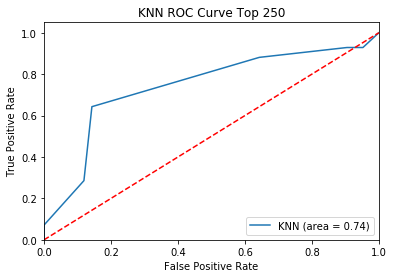

In [19]:
knn_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve Top 250')
plt.legend(loc="lower right")
plt.savefig('charts/KNN_ROC_Curve_Top_250.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

Top_500

In [14]:
knn_total_top_500.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,k,f1_score,jaccard_score,random_state,nFeatures
49863,"['Hotel', 'Cafe', 'Company', 'Liffey', 'Price ...",0.729167,16,0.639183,0.481204,72,5
49146,"['Hotel', 'Company']",0.723958,18,0.694792,0.537506,72,2


In [20]:
dff = df.loc[df['Ranking'] <= 1500].copy() # 500/1500 to keep y.var() close to unit
n=10
X = np.asarray(dff[['Hotel', 'Cafe', 'Company', 'Liffey', 'Price Area']])
y = np.asarray(dff['Top_500']) #Top_250/Top_500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)
clf = KNeighborsClassifier(n_neighbors = n)
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('acc: {}'.format(metrics.accuracy_score(y_test, yhat)))
print('f1: {}'.format(f1_score(y_test, yhat, average='weighted')))
print('jaccard: {}'.format(jaccard_score(y_test, yhat, average='weighted')))

acc: 0.6875
f1: 0.676954094292804
jaccard: 0.5239470108695652


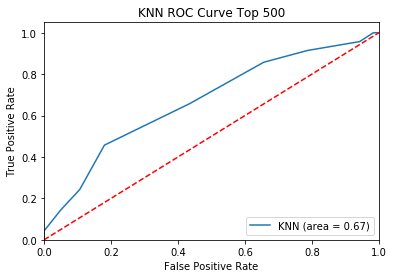

In [21]:
knn_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve Top 500')
plt.legend(loc="lower right")
plt.savefig('charts/KNN_ROC_Curve_Top_500.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### <a id="code4">Validation</a>

As we left 40 samples out of the scope to train the classifiers, let's see how they perform.<br>
Notice that all samples are negative, this means that in order to get 100% accuracy the classifier should predict 40 negatives and zero positives.

In [6]:
knn_total_top_250 = pd.read_csv('CSVs/knn_total_top_250.csv')
KNN_KF_CV_250 = pd.read_csv('CSVs/KNN_CV_top_feats_Top_250.csv')
knn_total_top_500 = pd.read_csv('CSVs/knn_total_top_500.csv')
KNN_KF_CV_500 = pd.read_csv('CSVs/KNN_CV_top_feats_Top_500.csv')

Top_250

In [11]:
dff = df.loc[df['Ranking'] <= 500].copy() # 500/1500 to keep y.var() close to unit
df_val = df.loc[df['Ranking'] > 1500] # 40 samples for validation.
val = pd.DataFrame()
results = [knn_total_top_250, KNN_KF_CV_250, KNN_KF_CV_250] #Top_250/Top_500
methods = ['random_state', 'KFold', 'cross_val_score']
acc_max = ['accuracy', 'KF_acc_max', 'CV_acc_max' ]

for acc, method, result in zip(acc_max, methods, results):
    feat_set = literal_eval(result.sort_values(by=[acc], ascending=False).head(1)['combo'].values[0])
    X_train = np.asarray(dff[feat_set])
    y_train = np.asarray(dff['Top_250']) #Top_250/Top_500
    X_val = np.asarray(df_val[feat_set])
    y_val = np.asarray(df_val['Top_250']) #Top_250/Top_500

    clf = KNeighborsClassifier(n_neighbors = 10)
    clf.fit(X_train, y_train)

    yhat = clf.predict(X_val)
    val_temp = pd.DataFrame([confusion_matrix(y_val, yhat)[0,:]], 
             columns=['Predicted Negative', 'Predicted Positive'], index=[method])
    val = val.append(val_temp)
val.index.name = 'Method' 
val['Accuracy %'] = round(100*(val['Predicted Negative']/
                                 (val['Predicted Negative']+val['Predicted Positive'])), 2)
knn_val_Top_250 = val.copy()  #Top_250/Top_500
knn_val_Top_250.to_csv('CSVs/KNN_val_Top_250.csv')
knn_val_Top_250

,Predicted Negative,Predicted Positive,Accuracy %
Method,,,
random_state,130,97,57.27
KFold,120,107,52.86
cross_val_score,116,111,51.10


Top_500

In [13]:
dff = df.loc[df['Ranking'] <= 1500].copy() # 500/1500 to keep y.var() close to unit
df_val = df.loc[df['Ranking'] > 1500] # 40 samples for validation.
val = pd.DataFrame()
results = [knn_total_top_500, KNN_KF_CV_500, KNN_KF_CV_500] #Top_250/Top_500
methods = ['random_state', 'KFold', 'cross_val_score']
acc_max = ['accuracy', 'KF_acc_max', 'CV_acc_max' ]

for acc, method, result in zip(acc_max, methods, results):
    feat_set = literal_eval(result.sort_values(by=[acc], ascending=False).head(1)['combo'].values[0])
    X_train = np.asarray(dff[feat_set])
    y_train = np.asarray(dff['Top_500']) #Top_250/Top_500
    X_val = np.asarray(df_val[feat_set])
    y_val = np.asarray(df_val['Top_500']) #Top_250/Top_500

    clf = KNeighborsClassifier(n_neighbors = 10)
    clf.fit(X_train, y_train)

    yhat = clf.predict(X_val)
    val_temp = pd.DataFrame([confusion_matrix(y_val, yhat)[0,:]], 
             columns=['Predicted Negative', 'Predicted Positive'], index=[method])
    val = val.append(val_temp)
val.index.name = 'Method' 
val['Accuracy %'] = round(100*(val['Predicted Negative']/
                                 (val['Predicted Negative']+val['Predicted Positive'])), 2)
knn_val_Top_500 = val.copy()  #Top_250/Top_500
knn_val_Top_500.to_csv('CSVs/KNN_val_Top_500.csv')
knn_val_Top_500

,Predicted Negative,Predicted Positive,Accuracy %
Method,,,
random_state,186,41,81.94
KFold,185,42,81.50
cross_val_score,183,44,80.62


### Diamond shape of charts versus nFeatures

At higher number of combinations (5 & 6 nFeatures) there is more probability to find extreme max and min (farest from the mean accuracy) running the classifier

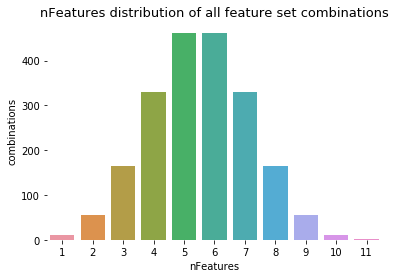

In [1363]:
nFeatures_combo = {}
for i in range(1,12):
    nFeatures_combo[i]=0
for combo in feat_combo:
    nFeatures_combo[len(combo)] +=1   
plt.title('nFeatures distribution of all feature set combinations', fontsize=13)
sns.barplot(x=list(nFeatures_combo.keys()), y=list(nFeatures_combo.values()))
plt.xlabel('nFeatures')
plt.ylabel('combinations')
plt.savefig('charts/nFeatures_dist_feat_combo.png', bbox_inches='tight', format='png', dpi=500)

### <center><a href="./D.Prediction_Models_DTree.ipynb#code0">NEXT CHAPTER</a></center>

#### <center> <a href="./0.Table_of_Contents_Code.ipynb">Table of Contents</a><br></center>